In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split

import nltk

import string

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from nltk.stem import SnowballStemmer

nltk.download('punkt')

nltk.download('stopwords')

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import precision_score, recall_score, precision_recall_curve

import matplotlib.pyplot as plt

from sklearn.metrics import plot_precision_recall_curve

import numpy as np

from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Костя\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Костя\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('labeled.csv.zip', sep=',')

In [4]:
df.shape

(14412, 2)

In [5]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [6]:
# Приведение колонки toxic к типу int
df.toxic = df.toxic.apply(int)

In [7]:
# Распределение класов 0 и 1
df.toxic.value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [8]:
# Разбивание датасета на треин и тест
train_df, test_df = train_test_split(df, test_size=500)

In [9]:
snowball = SnowballStemmer(language='russian')
rus_stop_words = stopwords.words('russian')

def tokenize_sentence (sentence: str, remove_stop_words: bool = True):
    '''
    tokenize_sentence: разбивает предложения на токены (т.е. на отдельные слова в предложении)
    
    param:
    sentence - предложение
    remove_stop_words - True (без стоп слов), False (со стоп словами)
    '''
    # Токенизация предложения
    tokens = word_tokenize(sentence, language='russian')
    
    # Запись без знаков пунктуации
    tokens = [i for i in tokens if i not in string.punctuation]
    
    # Удаление стоп слов если флаг True
    if remove_stop_words:
        tokens = [i for i in tokens if i not in rus_stop_words]
    
    # Стемминг слов (приведение к корню слова)
    tokens = [snowball.stem(i) for i in tokens]
    
    return tokens
    

In [10]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x))

In [11]:
features = vectorizer.fit_transform(train_df['comment'])

In [12]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df['toxic'])

LogisticRegression(random_state=0)

In [13]:
model.predict(features[0])

array([1], dtype=int64)

In [14]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x))),
    ('model', LogisticRegression(random_state=0))
])

In [15]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001B3314128B0>)),
                ('model', LogisticRegression(random_state=0))])

In [16]:
model_pipeline.predict(['пример текста для проверки нейтрального коммента'])

array([0], dtype=int64)

In [17]:
model_pipeline.predict(['пример текста тупого'])

array([1], dtype=int64)

In [18]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.9426229508196722

In [19]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.6804733727810651

In [24]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df['toxic'], probas_pred=model_pipeline.predict_proba(test_df['comment'])[:,1])

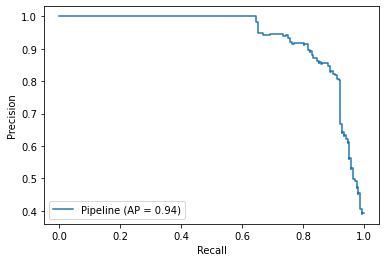

In [22]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df['comment'], y=test_df['toxic'])

In [25]:
np.where(prec > 0.95)

(array([314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
        366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
        379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
        392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
        405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
        418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429],
       dtype=int64),)

In [26]:
thresholds[374]

0.7695060435996066

In [27]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[374])

1.0

In [28]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[374])

0.31952662721893493

In [32]:
grid_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x))),
    ('model', GridSearchCV(LogisticRegression(random_state=0),
    param_grid={'C': [0.1, 0.2, 0.3, 0.5, 1]},
    cv=3,
    verbose=4))
    
])

In [33]:
grid_pipeline.fit(train_df['comment'], train_df['toxic'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.688, total=   0.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................... C=0.1, score=0.686, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.684, total=   0.1s
[CV] C=0.2 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] ............................... C=0.2, score=0.730, total=   0.2s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.730, total=   0.1s
[CV] C=0.2 ...........................................................
[CV] ............................... C=0.2, score=0.732, total=   0.1s
[CV] C=0.3 ...........................................................
[CV] ............................... C=0.3, score=0.765, total=   0.2s
[CV] C=0.3 ...........................................................
[CV] ............................... C=0.3, score=0.762, total=   0.1s
[CV] C=0.3 ...........................................................
[CV] ............................... C=0.3, score=0.764, total=   0.2s
[CV] C=0.5 ...........................................................
[CV] ............................... C=0.5, score=0.799, total=   0.2s
[CV] C=0.5 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.4s finished


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001B333EB8310>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 0.2, 0.3, 0.5, 1]},
                              verbose=4))])

In [37]:
grid_pipeline.predict(test_df['comment'])


array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,

In [38]:
precision_score(test_df['toxic'], grid_pipeline.predict(test_df['comment']))

0.9426229508196722

In [39]:
recall_score(test_df['toxic'], grid_pipeline.predict(test_df['comment']))


0.6804733727810651